### Lennard-Jones melt

The `Lennard-Jones` melt, or commonly referred to as the `LJ` melt is hello world analog in Molecular Dynamics (MD). the simulation system consists of `N` particles interacting with each other via the `12-6` Lennard Jones potential given by

$$
U(r) = 4 \epsilon \left[\left(\frac{\sigma}{r}\right)^{12}  - \left(\frac{\sigma}{r}\right)^6\right]
$$

where

* $\epsilon$ is the interaction strength of the potential
* $\sigma$ is the interaction length scale (distance at which the $U(r) = 0$)
* $r$ is the radial distance between two interacting particles

This potential is quite frequently used in MD simulations when one wishes to implement simple pair wise, non-bonded interactions between particles. LJ potentials are widely used when studying coarse-grained polymer melts and nano-composites and are known to generate realisitc intermolecular interactions in MD systems.


Let's see the shape of the potential by simply plotting it for $\epsilon=1$ and $\sigma=1$. To do this we begin by defining an aribtrary potential class that is a `callable`

### Potentials

In [1]:
class Potential(object):
    """
    Base class for all MD potentials
    """
    def __init__(self, name: str):
        self.name = name

    def __call__(self, r: float):
        raise NotImplementedError

In [2]:
import covamd

Now that we have created a `base` potential class, we now create the `LennardJones` potential class by subclassing it and providing an implementation for the `def __call__` method

In [3]:
class LennardJones(Potential):
    """
    Lennard Jones 12-6 potential class
    Input(s)
    epsilon = interaction strength
    sigma = potential interaction length scale
    cutoff = distance beyond which the potential is zero
    """
    def __init__(self, epsilon: float, sigma: float, cutoff: float = 2.5, name = "lj12/6"):
        self.epsilon = epsilon
        self.sigma = sigma
        self.cutoff = cutoff
        super().__init__(name=name)

    def __call__(self, r: float):
        """
        Compute the potential value given the distance `r`.
        The potential is set to 0 if r > cutoff
        """
        if r <= self.cutoff:
            return 4*self.epsilon*((self.sigma/r)**12 - (self.sigma/r)**6)
        return 0.0
        

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# %matplotlib notebook

In [5]:
r = np.linspace(0.95, 3, 1000)
lj_potential = LennardJones(epsilon=1.0, sigma=1.0)

Ur = [lj_potential(value) for value in r]

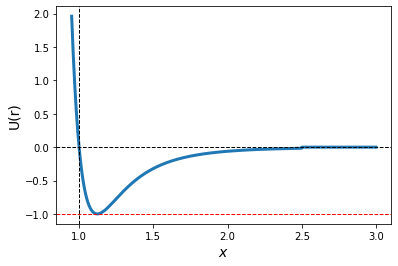

In [6]:
plt.plot(r, Ur, '-', lw=3)
plt.axhline(y = 0.0, linestyle='--', lw=1, color='k')
plt.axhline(y = -1.0, linestyle='--', lw=1, color='r')
plt.axvline(x=1.0, linestyle='--', lw=1, color='k')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'U(r)', fontsize=14)
plt.show()

### Forces

Once the interation potentials have been defined, the forces acting on the particles can be derived by taking its gradient

$$
\mathbf{F}(\mathbf{r}) = - \nabla U\left(\mathbf{r}\right)
$$

In a system of N particles, the force acting on the $i^{th}$ particle due to its interactions with every other particle in the system can be represented as

$$
\mathbf{F}_{i} = - \nabla_{\mathbf{r}_{i}} U\left(\mathbf{r}_1, \mathbf{r}_2, \ldots, \mathbf{r}_N\right)
$$

In our case, since we know the functional, closed form of the Lennard Jones potential, we can simply differentiate it w.r.t to $r$ and derive a close for expression for the Lennard-Jones force. This can be expressed as

$$
\mathbf{F}(r) = - \frac{\partial U}{\partial r} = 48 \epsilon \left(\frac{\sigma^{12}}{r^{13}} - \frac{\sigma^6}{2 r^7}\right)
$$

and looks as follows for LJ, $\epsilon, \sigma = 1.0$

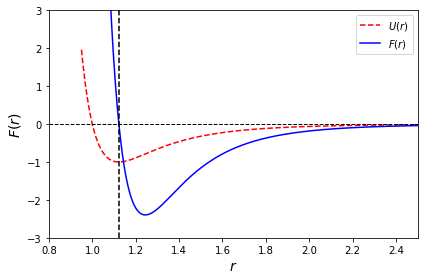

In [7]:
ljforce = lambda r: 48*(1.0/r**13 - 1.0/(2.0*r**7))


plt.plot(r, Ur, '--', color='r', label=r'$U(r)$')
plt.plot(r, ljforce(r), '-', color='b', label=r'$F(r)$')
plt.axhline(y=0.0, linestyle='--', color='k', lw=1)
plt.axvline(x=2**(1.0/6.0), linestyle='--', color='k')
plt.xlim([0.8, 2.5])
plt.ylim([-3.0, 3])
plt.xlabel(r'$r$', fontsize=14)
plt.ylabel(r'$F(r)$', fontsize=14)
plt.legend()
plt.tight_layout()

The minimum of the potential can be shown to be equal to $r_{0} = 2^{1/6} \sigma$ and we can see from the above figure that the force is negative i.e attractive. With this simple derivation we can see how the Lennard Jones potential can be used to represent interactions between particles in a MD simulation.

Generally speaking, computing the forces acting on particles becomes a trivial exercise when the closed form solution of the potential is known apriori. Generally speaking the potentials involved in large scale simulations are rather complicated and non-trivial to be expressed as closed form expressions. To simplify the situation in our case, we can simply numerically differentiate a given `Potential` object by using finite differences. There are several finite difference schemes available in practice, in this work we however use the `central difference` scheme to implement a generic MD force class that takes a potential as its input

Central differnce scheme
$$
\frac{d f}{dx} \approx \frac{f(x + \Delta) - f(x - \Delta)}{2\Delta}
$$
where $\Delta << 1 $ and is a small perturbation around $x$.

Using this, we can easily write down an expression that can yield the force acting on a particle given any object of type `Potential` as follows


```
force = -(Potential(r + Delta) - Potential(r - Delta))/(2*Delta)
```

Using such an expression will allow us to easily experiment with different potential types while not having to bother about writing the closed for expression of the force for each case. We create a `lambda` to convienietly compute the force at a given value of $r$ for any given object of type `Potential`

In [8]:
md_force = lambda r, potential: -(potential(r + 1e-8) - potential(r - 1e-8))/(2*(1e-8))

Deriving the force this way from the potential is of course an approximation and its accuracy can be compared against the true value in the Lennard Jones case.

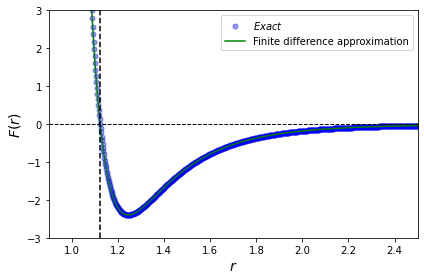

In [9]:
plt.plot(r, ljforce(r), 'o', ms=5, alpha=0.4, color='b', label=r'$Exact$')
approx = [md_force(value, LennardJones(epsilon=1.0, sigma=1.0)) for value in r]
plt.plot(r, approx, '-', color='g', label=r'Finite difference approximation')
plt.axhline(y=0.0, linestyle='--', color='k', lw=1)
plt.axvline(x=2**(1.0/6.0), linestyle='--', color='k')
plt.xlim([0.9, 2.5])
plt.ylim([-3.0, 3])
plt.xlabel(r'$r$', fontsize=14)
plt.ylabel(r'$F(r)$', fontsize=14)
plt.legend()
plt.tight_layout()

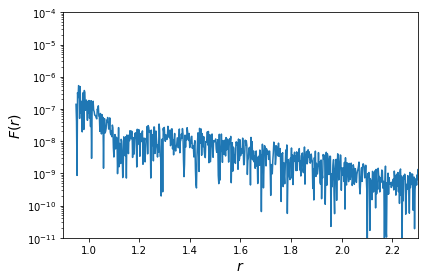

In [10]:
approx = np.asarray([md_force(value, LennardJones(epsilon=1.0, sigma=1.0)) for value in r])
plt.plot(r, np.abs(ljforce(r) - approx), '-')
plt.yscale('log')
plt.xlim([0.9, 2.3])
plt.ylim([10e-12, 10e-5])
plt.xlabel(r'$r$', fontsize=14)
plt.ylabel(r'$F(r)$', fontsize=14)
plt.tight_layout()

### Simulation domain

In [11]:
from __future__ import annotations
from typing import List, Callable
from functools import partial
import covalent as ct
import numpy as np
import os
from shutil import rmtree
import re
import copy
from covalent import electron
from matplotlib.animation import FuncAnimation

#### Simulation domain

In [12]:
class Domain(object):
    def __init__(self, xlo: float, xhi: float, ylo: float, yhi: float):
        self.xlo = xlo
        self.xhi = xhi
        self.ylo = ylo
        self.yhi = yhi


    @property
    def lx(self):
        return self.xhi - self.xlo

    @property
    def ly(self):
        return self.yhi - self.ylo

### MD particle

In [13]:
class Particle(object):
    def __init__(self, id: int, mass: float, x: float, y: float,
                 vx: float = 0.0, vy: float = 0.0, fx: float = 0.0,
                 fy: float = 0.0):
        """
        Basic particle
        """
        self.id = id
        self.mass = mass
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.fx = fx
        self.fy = fy

    def __eq__(self, other):
        return all([other.__dict__[key] == value for key, value in
                   self.__dict__.items()])

    def __sub__(self, other):
        return self.x - other.x, self.y - other.y

    def __repr__(self):
        return f"Particle(id={self.id}, mass={self.mass},x={self.x},\
                y={self.y},vx={self.vx},vy={self.vy},\
                fx={self.fx},fy={self.fy})".replace('\n', '')

    def __str__(self):
        return f"""{self.id},{self.mass},{self.x},{self.y},{self.vx},{self.vy},{self.fx},{self.fy}\n"""

def create_particle(id: int, mass: float, domain: Domain):
    """
    Create a particle with id=`id` and mass=`mass' randomly
    located in the domain
    """
    return Particle(id=id, mass=mass,
                    x=np.random.uniform(domain.xlo, domain.xhi),
                    y=np.random.uniform(domain.ylo, domain.yhi))

In [14]:
@ct.electron
def check_pbc(x: float, L: float):
    if x > L*0.5:
        return x - L
    if x <= -L*0.5:
        return x + L
    return x

In [15]:
@ct.electron
def total_pe(particles: List[Particle], potential, domain: Domain):
    total = 0.0
    for i in particles:
        for j in particles:
            if i == j:
                continue
            else:
                dx, dy = i - j
                dx = check_pbc(dx, domain.lx)
                dy = check_pbc(dy, domain.ly)
                
                dr = np.sqrt(dx**2 + dy**2)
                total += potential(dr)
    return total/2.0

In [16]:
@ct.electron
def grad_pe(particles: List[Particle], potential, domain: Domain, epsilon: float = 1e-8):
    grad = []
    for p in particles:
        pe = total_pe(particles=particles, potential=potential, domain=domain)
        p.x += epsilon
        pe_delta = total_pe(particles=particles, potential=potential, domain=domain)
        dudpx = (pe_delta - pe)/epsilon
        p.x -= epsilon
        
        p.y += epsilon
        pe_delta = total_pe(particles=particles, potential=potential, domain=domain)
        dudpy = (pe_delta - pe)/epsilon
        p.y -= epsilon
        
        grad.append(dudpx)
        grad.append(dudpy)
        
    return grad

### Save particles to file

In [17]:
@ct.electron
def save_snapshot(particles: List[Particle], step: int):
    if not os.path.isdir("/home/venkat/agnostiq-rpi-tutorials/snapshots"):
        os.mkdir("/home/venkat/agnostiq-rpi-tutorials/snapshots")
    dump_file=f"/home/venkat/agnostiq-rpi-tutorials/snapshots/system_{step}.txt"
    
    with open(dump_file, "w") as f:
        for particle in particles:
            f.write(str(particle))
        f.close()

In [18]:
@ct.electron
def minimize_system_energy(objective, particles, grad, domain, options = {}, *args, **kwargs):
    """
    Given a system, minimize its potential energy using gradient descent
    """
    try:
        learning_rate = options["learning_rate"]
    except KeyError:
        learning_rate = 1e-3
        
    try:
        tol = options["tol"]
    except KeyError:
        tol = 1e-5
        
    try:
        maxiter = options["maxiter"]
    except KeyError:
        maxiter = 500
        
    try:
        verbose = options["verbose"]
    except KeyError:
        verbose = False
        
    
    x = copy.deepcopy(particles)
    fold = objective(x)
    i = 0
    diff = 1e10
    diff_history = [diff]
    f_history = [fold]
    dx = np.zeros(2*len(x))
        
    while i < maxiter and diff > tol:
        dx = -learning_rate*np.asarray(grad(x))
            
        for index, particle in enumerate(x):
            particle.x += dx[index]
            particle.y += dx[index+1]
                
            particle.x = particle.x%domain.lx
            particle.y = particle.y%domain.ly
            
        #save_snapshot(x, i)
                
        fnew = objective(x)
        diff = np.abs(fnew - fold)
        fold = fnew
        diff_history.append(diff)
        f_history.append(fnew)
        
        if verbose:
            print(i, fnew)
            
        #if fnew < 0.0:
        #   learning_rate /= 4
                
        if i % 10 == 0:
            learning_rate /= 2
            
        i += 1
        
    return x, fnew, i

In [19]:
@ct.electron
def gradient_descent_particle_update(particles: List[Particle], dx: List[float], domain: Domain):
    for index, particle in enumerate(particles):
        particle.x += dx[index]
        particle.y += dx[index+1]
        
        particle.x = particle.x%domain.lx
        particle.y = particle.y%domain.ly
        
    return particles

@ct.electron
def check_loss(f_old: float, f_new: float):
    return abs(f_new - f_old)

In [20]:
@ct.electron
def init_velocities(particles: List[Particle]):
    for particle in particles:
        particle.vx = np.random.randn()
        particle.vy = np.random.randn()
    return particles


@ct.electron
def scale_gradients(gradients: List[float], lr: float):
    res = []
    for value in gradients:
        res.append(-1.0*lr*value)
    return res

@ct.electron
def update_learning_rate(lr: float, f: float, step: int):
    if f < 0.0:
        return lr / 4.0
    
    if step % 10 == 0:
        return lr / 2.0
    return lr

In [21]:
@ct.electron
def euler_step(particles, dt: float):
    for particle in particles:
        particle.x += particle.vx*dt
        particle.y += particle.vy*dt
        
    return particles

@ct.electron
def lj_force(r, epsilon, sigma):
    """
    Implementation of the Lennard-Jones potential 
    to calculate the force of the interaction.
    
    Parameters
    ----------
    r: float
        Distance between two particles (Å)
    epsilon: float 
        Potential energy at the equilibrium bond 
        length (eV)
    sigma: float 
        Distance at which the potential energy is 
        zero (Å)
    
    Returns
    -------
    float
        Force of the van der Waals interaction (eV/Å)
    """
    return 48 * epsilon * np.power(
        sigma / r, 13) - 24 * epsilon * np.power(
        sigma / r, 7)

@ct.electron
def update_forces(particles: List[Particle], potential: Potential, domain: Domain):
    #particles_copy = copy.deepcopy(particles)
    for i in particles:
        i.fx = 0.0
        i.fy = 0.0
        for j in particles:
            if i == j:
                continue
            else:
                dx, dy = i - j
                #dx = dx%domain.lx
                #dy = dy%domain.ly
                
                dx = check_pbc(dx, domain.lx)
                dy = check_pbc(dy, domain.ly)
                
                dr = np.sqrt(dx**2 + dy**2)
                
                f = lj_force(dr, 1.0, 1.0)
                
                #f = -(potential(dr+1e-8) - potential(dr-1e-8))/(2*1e-8)
                
                fx = (dx/dr)*f
                fy = (dy/dr)*f
                
                i.fx += fx/2.0
                i.fy += fy/2.0
    return particles


@ct.electron
def verlet_integration(step: int, particles: List[Particles], particles_prev: List[Particles],
                       potential: Potential, domain: Domain,dt: float):
    p_copy = copy.deepcopy(particles)

    if step == 0:
        for particle in particles:
            particle.x += particle.vx*dt
            particle.y += particle.vy*dt
            
            particle.x = particle.x%domain.lx
            particle.y = particle.y%domain.ly
    else:
        particles = update_forces(particles, potential, domain)
    
        #particles_copy = copy.deepcopy(particles)
        for index, particle in enumerate(particles):
            particle.x = 2*particle.x - particles_prev[index].x + particle.fx*dt**2
            particle.y = 2*particle.y - particles_prev[index].y + particle.fy*dt**2
            particle.x = particle.x%domain.lx
            particle.y = particle.y%domain.ly
            #print(index, particle.x, particle.y, particle.vx, particle.vy, particle.fx, particle.fy)
        
    return particles, p_copy

In [22]:
@ct.electron
def velocity_verlet_integration(particles: List[Particle], potential, domain, dt):
    particles = update_forces(particles, potential, domain)

    # Update positions
    for particle in particles:
        particle.x = particle.x + particle.vx*dt + (particle.fx/(2*particle.mass))*dt**2
        particle.y = particle.y + particle.vy*dt + (particle.fy/(2*particle.mass))*dt**2
        particle.x = particle.x%domain.lx
        particle.y = particle.y%domain.ly
        
    # Update forces
    particles_copy = update_forces(particles, potential, domain)
    
    # Update velocities
    for index, particle in enumerate(particles):
        particle.vx = particle.vx + dt*(particles_copy[index].fx+particle.fx)/(2*particle.mass)
        particle.vy = particle.vy + dt*(particles_copy[index].fy+particle.fy)/(2*particle.mass)
        
    return particles

In [23]:
@ct.electron
def run(nsteps, particles: List[Particles], potential: Potential, domain: Domain, dt: float):
    #p0 = copy.deepcopy(particles)
    for i in range(nsteps):
        particles = velocity_verlet_integration(particles=particles, potential=potential, domain=domain, dt=dt)
        
        #total_energy = total_energy(particles=particles, potential=potential, domain=domain)
        # p2
        #particles_next, p1 = verlet_integration(step=i, particles=particles,
                                                            #particles_prev=p0,
                                                            #potential=potential,
                                                            #domain=domain, dt=1e-4)
        #particles_prev=particles
        #particles = copy.deepcopy(particles_next)
        #p0 = copy.deepcopy(p1)
        
        save_snapshot(particles, i)
    return particles

In [24]:
@ct.lattice
def simulation(particles: List[Particle], domain: Domain, potential: Potential, nsteps):
    """
    run a basic MD particle simulation
    """
    i = 0
    # Compute the system initial potential energy
    f_old = total_pe(particles, potential, domain=domain)
    
    # Minimize system energy
    objective = partial(total_pe, potential=potential, domain=domain)
    gradient = partial(grad_pe, potential=potential, domain=domain)
    
    #loss_value = 1e10
    
    #for i in range(maxiter):
    #    gradients = gradient(particles)
    #    dx = scale_gradients(gradients=gradients, lr=lr)
        
        # Update particle positions
    #    particles = gradient_descent_particle_update(particles=particles, dx=dx, domain=domain)
        
        # Save system
    #    save_snapshot(particles, i)
        
        # Compute potential energy
    #    f_new = objective(particles)
        
        # Check loss
    #    loss = check_loss(f_old=f_old, f_new=f_new, tol=tol)
        
    #    f_old = f_new
        
        # update learning rate based on f_new and step
    #    lr = update_learning_rate(lr, f_new, i)
        
    #    i += 1
        
    particles, final_energy, num_iterations = minimize_system_energy(objective, particles, gradient, domain,
                                                                     options={"maxiter": 200, "tol": 1e-5,
                                                                              "learning_rate": 1e-2,
                                                                              "verbose": True})
    
    
    # Initialize velocities
    particles = init_velocities(particles)
    
    
    # Compute total energy
    #pe = total_pe(particles=particles, potential=potential, domain=domain)
    
    #ke = total_ke(particles=particles)
    
    #total_energy = pe + ke
    
    # Integrate
    particles = run(nsteps=nsteps,
                    particles=particles,
                    potential=potential,
                    domain = domain,
                    dt=1e-2)
        
    
    # Start integrating
    #p0 = particles # copy

    #for i in range(nsteps):
        # p2
    #    particles, p1 = verlet_integration(step=i, particles=particles, particles_prev=p0,
    #                                       potential=potential, domain=domain, dt=1e-4)
    #    p0 = p1
        
    #    save_snapshot(particles, i)
        

    return {"particles": particles, "iters": nsteps}

In [25]:
domain = Domain(xlo = 0, xhi = 20, ylo = 0, yhi = 20)
num_particles = 30
nsteps = 1000
particles = [create_particle(id=index, mass=1.0, domain = domain) for index in range(num_particles)]

if os.path.isdir("/home/venkat/agnostiq-rpi-tutorials/snapshots"):
    rmtree("/home/venkat/agnostiq-rpi-tutorials/snapshots")
    
#res = simulation(particles, domain, LennardJones(epsilon=1.0, sigma=1.0), nsteps)

In [26]:
import covamd

In [27]:
covamd.total_pe(particles, LennardJones(epsilon=1.0, sigma=1.0), domain)

hereParticles is at a1439d00
size of particles 30
Coordinate of particle 0 0.000000


SystemError: <built-in function total_pe> returned a result with an error set

In [ ]:
particles[0].x

In [ ]:
#res = ct.dispatch_sync(simulation)(particles, domain, LennardJones(epsilon=1.0, sigma=1.0), nsteps)

In [ ]:
#res.result

In [ ]:
def animate(frame_number):
    data = np.loadtxt(f"/home/venkat/agnostiq-rpi-tutorials/snapshots/system_{frame_number}.txt", delimiter=",")
    x = data[:, 2]
    y = data[:, 3]
    line.set_data((x, y))
    return line

In [ ]:
fig, ax = plt.subplots()

line, = ax.plot([], 'o', ms=10)     # A tuple unpacking to unpack the only plot
ax.set_xlim(domain.xlo, domain.xhi)
ax.set_ylim(domain.ylo, domain.yhi)

anim = FuncAnimation(fig, animate, frames=nsteps, interval=10)
anim.save("test.mp4")
plt.show()